In [112]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [113]:
data = pd.read_csv('toolwindow_data.csv')

In [114]:
data.head()

,timestamp,event,open_type,user_id
0,1752250204033,opened,manual,1
1,1751836141616,closed,NaN,2
2,1752304475081,closed,NaN,3
3,1752498934494,opened,auto,4
4,1752141991110,closed,NaN,5


### Initial Data Analysis

In [115]:
data.isna().any()

timestamp    False
event        False
open_type     True
user_id      False
dtype: bool

In [116]:
data = data.sort_values(by=["user_id","timestamp"] )

In [117]:
data

,timestamp,event,open_type,user_id
3481,1751826102123,opened,auto,1
1803,1751826746077,closed,NaN,1
2757,1751841258635,opened,manual,1
46,1751849544609,closed,NaN,1
1296,1751985487772,opened,manual,1
...,...,...,...,...
2828,1752063311786,opened,auto,202
2847,1751993622531,opened,auto,203
3454,1751993632485,closed,NaN,203
2848,1752107530446,opened,auto,204


In [118]:
data[(data["event"] == "opened") & data["open_type"].isna()]


,timestamp,event,open_type,user_id


In [119]:
data[(data["event"] == "opened") & data["open_type"].notna()]

,timestamp,event,open_type,user_id
3481,1751826102123,opened,auto,1
2757,1751841258635,opened,manual,1
1296,1751985487772,opened,manual,1
0,1752250204033,opened,manual,1
1013,1752250205587,opened,manual,1
...,...,...,...,...
3321,1751853675253,opened,manual,201
2828,1752063311786,opened,auto,202
2847,1751993622531,opened,auto,203
2848,1752107530446,opened,auto,204


In [120]:
data[(data["event"] == "closed")].count()

timestamp    1638
event        1638
open_type       0
user_id      1638
dtype: int64

In [121]:
data = data.reset_index(drop=True) 

In [122]:
data

,timestamp,event,open_type,user_id
0,1751826102123,opened,auto,1
1,1751826746077,closed,NaN,1
2,1751841258635,opened,manual,1
3,1751849544609,closed,NaN,1
4,1751985487772,opened,manual,1
...,...,...,...,...
3498,1752063311786,opened,auto,202
3499,1751993622531,opened,auto,203
3500,1751993632485,closed,NaN,203
3501,1752107530446,opened,auto,204


In [ ]:
#For each user_id, the balance between opened and closed events was calculated to identify unpaired cases.
unpairedIds = {}

for user_id, group in data.groupby("user_id"):
    count = 0
    for _,row in group.iterrows():
        if row["event"] == "opened":
            count +=1
        elif row["event"] == "closed":
            count -=1
    unpairedIds[user_id] = count

In [124]:
for k,v in unpairedIds.items():
    if v<0:
        print(k)

182


In [125]:
#Checking how data look for one specific user
data[(data["user_id"] == 11)]

,timestamp,event,open_type,user_id
434,1751931468156,opened,auto,11
435,1751931975522,closed,NaN,11
436,1751933545782,opened,auto,11
437,1751996635802,closed,NaN,11
438,1751997219289,opened,auto,11
439,1751997242531,closed,NaN,11
440,1751997243046,opened,manual,11
441,1752146923434,opened,auto,11
442,1752147744069,closed,NaN,11
443,1752147744516,opened,manual,11


In [ ]:
# Retrieve the previous event per user to rebuild event sequences
# Record the previous event type and timestamp for comparison
# Calculate duration (in seconds) between consecutive events
data["prev_event"] = data.groupby("user_id")["event"].shift(1)
data["prev_open_type"] = data.groupby("user_id")["open_type"].shift(1)
data["prev_timestamp"] = data.groupby("user_id")["timestamp"].shift(1)
data["duration"] = (data["timestamp"] - data["prev_timestamp"])/1000

## Strategy 1

In this strategy:
- From every sequence of consecutive **"opened"** events, only the **first** one is kept.  
- From every sequence of consecutive **"closed"** events, only the **first** one is kept as well.  
- All **unpaired "opened" or "closed"** events are removed from the dataset.  

This ensures that each open–close episode is correctly represented and prevents duplicate or unmatched events from affecting the duration analysis.


In [ ]:
#This line removes consecutive opened events, keeping only the first one in each sequence.
strategy1 = data[~((data["event"] == "opened") & (data["prev_event"] == "opened"))]

In [128]:
strategy1

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration
0,1751826102123,opened,auto,1,NaN,NaN,NaN,NaN
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954
2,1751841258635,opened,manual,1,closed,NaN,1.751827e+12,14512.558
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974
4,1751985487772,opened,manual,1,closed,NaN,1.751850e+12,135943.163
...,...,...,...,...,...,...,...,...
3498,1752063311786,opened,auto,202,NaN,NaN,NaN,NaN
3499,1751993622531,opened,auto,203,NaN,NaN,NaN,NaN
3500,1751993632485,closed,NaN,203,opened,auto,1.751994e+12,9.954
3501,1752107530446,opened,auto,204,NaN,NaN,NaN,NaN


In [ ]:
strategy1 = strategy1.sort_values(["user_id", "timestamp"]).reset_index(drop=True)

# Repeat the same process as before, now using the dataset with only the first 'opened' in each sequence

strategy1["prev_event"] = strategy1.groupby("user_id")["event"].shift(1)
strategy1["prev_open_type"] = strategy1.groupby("user_id")["open_type"].shift(1)
strategy1["prev_timestamp"] = strategy1.groupby("user_id")["timestamp"].shift(1)
strategy1["duration2"] = (strategy1["timestamp"] - strategy1["prev_timestamp"])/1000

In [130]:
strategy1

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration,duration2
0,1751826102123,opened,auto,1,NaN,NaN,NaN,NaN,NaN
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954,643.954
2,1751841258635,opened,manual,1,closed,NaN,1.751827e+12,14512.558,14512.558
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974,8285.974
4,1751985487772,opened,manual,1,closed,NaN,1.751850e+12,135943.163,135943.163
...,...,...,...,...,...,...,...,...,...
3289,1752063311786,opened,auto,202,NaN,NaN,NaN,NaN,NaN
3290,1751993622531,opened,auto,203,NaN,NaN,NaN,NaN,NaN
3291,1751993632485,closed,NaN,203,opened,auto,1.751994e+12,9.954,9.954
3292,1752107530446,opened,auto,204,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Remove consecutive identical events (at this time there are only consecutive closed events), and keep only the first one
strategy1 = strategy1[~(strategy1["event"] == strategy1["prev_event"])]

In [132]:
strategy1

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration,duration2
0,1751826102123,opened,auto,1,NaN,NaN,NaN,NaN,NaN
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954,643.954
2,1751841258635,opened,manual,1,closed,NaN,1.751827e+12,14512.558,14512.558
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974,8285.974
4,1751985487772,opened,manual,1,closed,NaN,1.751850e+12,135943.163,135943.163
...,...,...,...,...,...,...,...,...,...
3289,1752063311786,opened,auto,202,NaN,NaN,NaN,NaN,NaN
3290,1751993622531,opened,auto,203,NaN,NaN,NaN,NaN,NaN
3291,1751993632485,closed,NaN,203,opened,auto,1.751994e+12,9.954,9.954
3292,1752107530446,opened,auto,204,NaN,NaN,NaN,NaN,NaN


In [133]:
strategy1 = strategy1.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)

In [134]:
strategy1

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration,duration2
0,1751826102123,opened,auto,1,NaN,NaN,NaN,NaN,NaN
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954,643.954
2,1751841258635,opened,manual,1,closed,NaN,1.751827e+12,14512.558,14512.558
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974,8285.974
4,1751985487772,opened,manual,1,closed,NaN,1.751850e+12,135943.163,135943.163
...,...,...,...,...,...,...,...,...,...
3273,1752063311786,opened,auto,202,NaN,NaN,NaN,NaN,NaN
3274,1751993622531,opened,auto,203,NaN,NaN,NaN,NaN,NaN
3275,1751993632485,closed,NaN,203,opened,auto,1.751994e+12,9.954,9.954
3276,1752107530446,opened,auto,204,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Remove unmatched last opened events for each user:
lastRows = strategy1.groupby("user_id").tail(1).index

In [136]:
openedLast = strategy1.loc[lastRows]

In [137]:
openedLastIdx = openedLast[openedLast["event"] == "opened"].index

In [138]:
strategy1 = strategy1.drop(index = openedLastIdx)

In [139]:
strategy1

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration,duration2
0,1751826102123,opened,auto,1,NaN,NaN,NaN,NaN,NaN
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954,643.954
2,1751841258635,opened,manual,1,closed,NaN,1.751827e+12,14512.558,14512.558
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974,8285.974
4,1751985487772,opened,manual,1,closed,NaN,1.751850e+12,135943.163,135943.163
...,...,...,...,...,...,...,...,...,...
3270,1752502765595,closed,NaN,200,opened,manual,1.752503e+12,34.045,34.045
3271,1751853675253,opened,manual,201,NaN,NaN,NaN,NaN,NaN
3272,1751853683561,closed,NaN,201,opened,manual,1.751854e+12,8.308,8.308
3274,1751993622531,opened,auto,203,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Repeat calculation of balance between opened and closed events after applying strategy 1
unpairedIds = {}

for user_id, group in strategy1.groupby("user_id"):
    count = 0
    for _,row in group.iterrows():
        if row["event"] == "opened":
            count +=1
        elif row["event"] == "closed":
            count -=1
    unpairedIds[user_id] = count

In [ ]:
for k,v in unpairedIds.items():
    if v>0:
        print(k)
#Because there is no answer that means that there are none unpaired opened/closed episodes

In [ ]:
#I filtered the dataset to retain only the rows where the current event is closed, as each valid duration is defined by a completed open–close pair.
strategy1 = strategy1[strategy1["event"] == "closed"]

In [143]:
#Checking how user 11 looks now after applying all of our assumptions
strategy1[strategy1["user_id"]==11]

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration,duration2
427,1751931975522,closed,NaN,11,opened,auto,1.751931e+12,507.366,507.366
429,1751996635802,closed,NaN,11,opened,auto,1.751934e+12,63090.020,63090.020
431,1751997242531,closed,NaN,11,opened,auto,1.751997e+12,23.242,23.242
433,1752147744069,closed,NaN,11,opened,manual,1.751997e+12,820.635,150501.023
435,1752150557798,closed,NaN,11,opened,manual,1.752148e+12,2813.282,2813.282
437,1752502927215,closed,NaN,11,opened,manual,1.752197e+12,2.469,306325.053


### Percentile Threshold Selection

During the analysis, I observed that using this approach (Strategy 1) generally results in higher duration values compared to Strategy 2.  
To ensure consistency and enable meaningful comparison between the two strategies, I decided to use the **95th percentile threshold** as the main cutoff — the same threshold applied in Strategy 2.

Additionally, since the **92nd percentile (≈ 14,210 s)** in Strategy 1 is numerically close to the **95th percentile in Strategy 2 (≈ 14,100 s)**, it serves as a reasonable reference point for comparison.  
Including both thresholds allows me to examine whether differences in results are robust across slightly different but comparable cutoffs.


In [144]:
pp92 = strategy1["duration2"].quantile(0.92)
pp92

np.float64(14210.589240000001)

In [145]:
strategy95 = strategy1.copy()

In [ ]:
#Variable strategy95 contains data filtered to the 95th percentile case
pp95 = strategy95["duration2"].quantile(0.95)
pp95

np.float64(58200.10724999991)

In [147]:
strategy95 = strategy95[strategy95["duration2"] <= pp95]

In [148]:
strategy95

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration,duration2
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954,643.954
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974,8285.974
5,1751986623885,closed,NaN,1,opened,manual,1.751985e+12,1136.113,1136.113
7,1752250204781,closed,NaN,1,opened,manual,1.752250e+12,0.748,0.748
9,1752257432775,closed,NaN,1,opened,manual,1.752250e+12,7227.188,7227.188
...,...,...,...,...,...,...,...,...,...
3266,1751794914913,closed,NaN,198,opened,auto,1.751795e+12,125.748,125.748
3268,1752207181344,closed,NaN,199,opened,manual,1.752207e+12,22.863,22.863
3270,1752502765595,closed,NaN,200,opened,manual,1.752503e+12,34.045,34.045
3272,1751853683561,closed,NaN,201,opened,manual,1.751854e+12,8.308,8.308


In [ ]:
#Variable strategy1 contains data filtered to the 92nd percentile case
strategy1 = strategy1[strategy1["duration2"] <= pp92]

In [150]:
strategy1

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration,duration2
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954,643.954
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974,8285.974
5,1751986623885,closed,NaN,1,opened,manual,1.751985e+12,1136.113,1136.113
7,1752250204781,closed,NaN,1,opened,manual,1.752250e+12,0.748,0.748
9,1752257432775,closed,NaN,1,opened,manual,1.752250e+12,7227.188,7227.188
...,...,...,...,...,...,...,...,...,...
3266,1751794914913,closed,NaN,198,opened,auto,1.751795e+12,125.748,125.748
3268,1752207181344,closed,NaN,199,opened,manual,1.752207e+12,22.863,22.863
3270,1752502765595,closed,NaN,200,opened,manual,1.752503e+12,34.045,34.045
3272,1751853683561,closed,NaN,201,opened,manual,1.751854e+12,8.308,8.308


### Descriptive Statistics

Basic metrics such as **count**, **mean**, **standard deviation**, **min**, **max**, and **quartiles (25%, 50%, 75%)** were obtained using the `describe()` method.  
These values provide a quick overview of the data distribution and allow comparison between **manual** and **automatic** openings before deeper statistical analysis.


In [151]:
manual = strategy1[strategy1["prev_open_type"] == "manual"]["duration2"]

In [152]:
auto = strategy1[strategy1["prev_open_type"] == "auto"]["duration2"]

In [153]:
manual.describe()

count      611.000000
mean       418.192823
std       1499.597388
min          0.015000
25%          2.159500
50%         12.284000
75%        137.120500
max      14100.989000
Name: duration2, dtype: float64

In [154]:
auto.describe()

count      881.000000
mean      1002.656932
std       2279.787073
min          0.154000
25%         31.659000
50%        156.569000
75%        777.707000
max      14207.539000
Name: duration2, dtype: float64

In [ ]:
#Create subsets for manual and automatic openings (strategy 1: 92nd percentile case)

In [155]:
manual1 = strategy95[strategy95["prev_open_type"] == "manual"]["duration2"]

In [156]:
auto1 = strategy95[strategy95["prev_open_type"] == "auto"]["duration2"]

In [157]:
manual1.describe()

count      620.000000
mean       844.700900
std       4085.009624
min          0.015000
25%          2.215750
50%         13.115500
75%        145.698500
max      52725.404000
Name: duration2, dtype: float64

In [158]:
auto1.describe()

count      920.000000
mean      2343.336459
std       7325.284067
min          0.154000
25%         35.195500
50%        172.863000
75%        926.878250
max      57743.124000
Name: duration2, dtype: float64

In [ ]:
#Create subsets for manual and automatic openings (strategy 1: 95th percentile case)

### Statistical Significance Test

To check whether the difference in window duration between **manual** and **automatic** openings is statistically significant, I applied the **Mann–Whitney U test** (non-parametric alternative to the t-test).

This test was chosen because the data is not normally distributed.  
The resulting **p-values (< 0.001)** indicate a highly significant difference, confirming that manually opened tool windows tend to remain open for a shorter duration than automatically opened ones.


In [159]:
from scipy.stats import mannwhitneyu

In [ ]:
#Calculate statistics for strategy 1: 92nd percentile case
stat, p = mannwhitneyu(manual, auto, alternative='two-sided')

In [161]:
p

np.float64(2.72435196159057e-53)

In [ ]:
#Calculate statistics for strategy 1: 95th percentile case
stat1, p1 = mannwhitneyu(manual1, auto1, alternative='two-sided')

In [163]:
p1

np.float64(4.932066879745845e-55)

### Visualizing Duration Distributions

To better understand the overall behavior of tool window usage, it is useful to visualize the distribution of **open durations** for both manual and automatic events.  
While summary statistics provide general trends (mean, median, quartiles), they do not clearly show how durations are spread or whether there are extreme values.

Histograms allow for an intuitive comparison between the two groups, making it easier to observe:
- the overall shape of the distributions,
- potential outliers or long-duration cases,
- and differences in how frequently shorter or longer sessions occur.

By plotting these distributions side by side, we can directly compare user interaction patterns between manually and automatically opened tool windows.


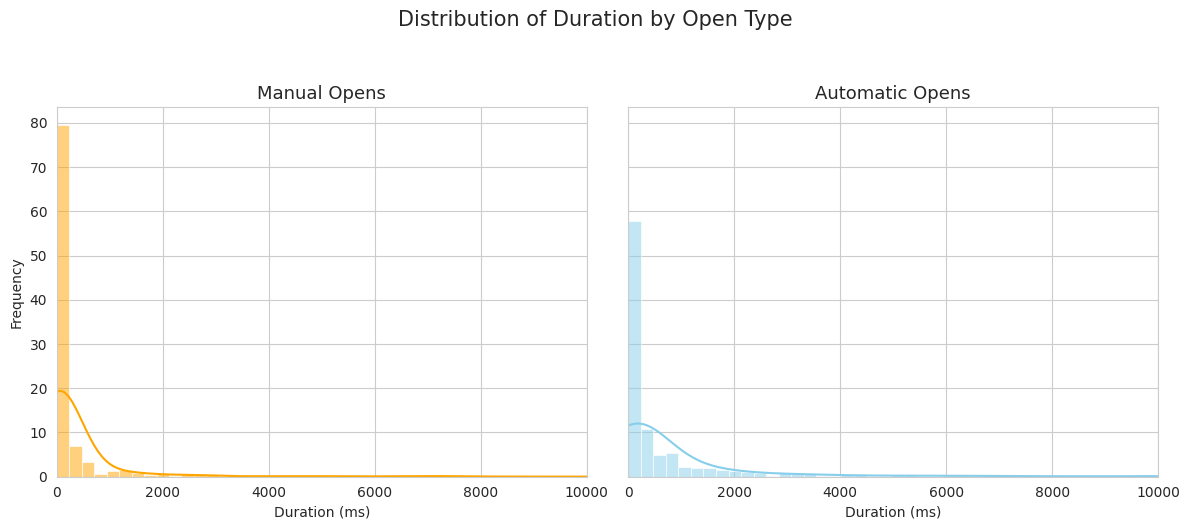

In [ ]:
#Plot histograms for strategy 1: 92nd percentile case
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(
    data=strategy1[strategy1["prev_open_type"] == "manual"],
    x="duration2",
    bins=60,
    kde=True,
    color="orange",
    ax=axes[0],
    stat="percent"
)
axes[0].set_title("Manual Opens", fontsize=13)
axes[0].set_xlabel("Duration (ms)")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(0, 10000) 

sns.histplot(
    data=strategy1[strategy1["prev_open_type"] == "auto"],
    x="duration2",
    bins=60,
    kde=True,
    color="skyblue",
    ax=axes[1],
    stat="percent"
)
axes[1].set_title("Automatic Opens", fontsize=13)
axes[1].set_xlabel("Duration (ms)")
axes[1].set_xlim(0, 10000) 

plt.suptitle("Distribution of Duration by Open Type", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()


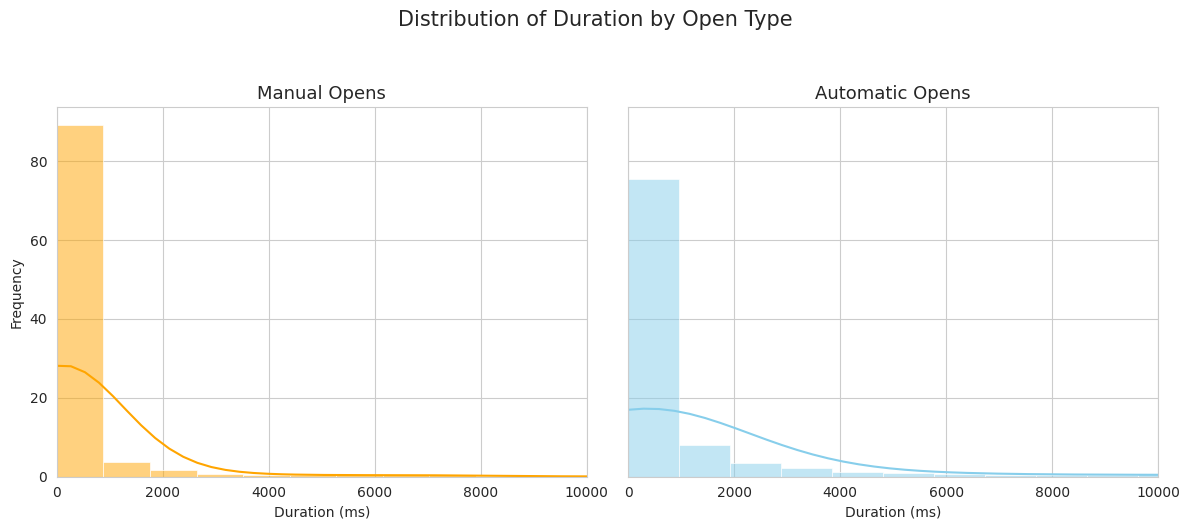

In [ ]:
#Plot histograms for strategy 1: 95th percentile case
import seaborn as sns


sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(
    data=strategy95[strategy95["prev_open_type"] == "manual"],
    x="duration2",
    bins=60,
    kde=True,
    color="orange",
    ax=axes[0],
    stat="percent"
)
axes[0].set_title("Manual Opens", fontsize=13)
axes[0].set_xlabel("Duration (ms)")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(0, 10000) 

sns.histplot(
    data=strategy95[strategy95["prev_open_type"] == "auto"],
    x="duration2",
    bins=60,
    kde=True,
    color="skyblue",
    ax=axes[1],
    stat="percent"
)
axes[1].set_title("Automatic Opens", fontsize=13)
axes[1].set_xlabel("Duration (ms)")
axes[1].set_xlim(0, 10000) 

plt.suptitle("Distribution of Duration by Open Type", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

In [166]:
data = data.sort_values(["user_id", "timestamp"]).reset_index(drop=True)

In [167]:
data

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration
0,1751826102123,opened,auto,1,NaN,NaN,NaN,NaN
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954
2,1751841258635,opened,manual,1,closed,NaN,1.751827e+12,14512.558
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974
4,1751985487772,opened,manual,1,closed,NaN,1.751850e+12,135943.163
...,...,...,...,...,...,...,...,...
3498,1752063311786,opened,auto,202,NaN,NaN,NaN,NaN
3499,1751993622531,opened,auto,203,NaN,NaN,NaN,NaN
3500,1751993632485,closed,NaN,203,opened,auto,1.751994e+12,9.954
3501,1752107530446,opened,auto,204,NaN,NaN,NaN,NaN


## Strategy 2

In this strategy:
- From every sequence of consecutive **"opened"** events, only the **last** one is kept.  
- From every sequence of consecutive **"closed"** events, only the **first** one is kept.  
- All **unpaired "opened" or "closed"** events are removed from the dataset.  

This approach intuitively results in **shorter open durations**, since it assumes that the last "open" event in a sequence represents the actual point when the tool window was finally activated before being closed.  

  


In [ ]:
#Similar to the previous logic, but applied to the next event to keep the last opened in each sequence
data["next_event"] = data.groupby("user_id")["event"].shift(-1)
data["next_open_type"] = data.groupby("user_id")["open_type"].shift(-1)

#Keep only last opened event
strategy2 = data[~((data["event"] == "opened") & (data["next_event"] == "opened"))]

In [ ]:
#Remove consecutive identical events (at this time there are only consecutive closed events), and keep only the first one
strategy2 = data[~(data["event"] == data["prev_event"])]

In [170]:
strategy2

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration,next_event,next_open_type
0,1751826102123,opened,auto,1,NaN,NaN,NaN,NaN,closed,NaN
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954,opened,manual
2,1751841258635,opened,manual,1,closed,NaN,1.751827e+12,14512.558,closed,NaN
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974,opened,manual
4,1751985487772,opened,manual,1,closed,NaN,1.751850e+12,135943.163,closed,NaN
...,...,...,...,...,...,...,...,...,...,...
3498,1752063311786,opened,auto,202,NaN,NaN,NaN,NaN,NaN,NaN
3499,1751993622531,opened,auto,203,NaN,NaN,NaN,NaN,closed,NaN
3500,1751993632485,closed,NaN,203,opened,auto,1.751994e+12,9.954,NaN,NaN
3501,1752107530446,opened,auto,204,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
strategy2 = strategy2.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)

In [ ]:
#Remove unmatched events
lastRows = strategy2.groupby("user_id").tail(1).index

In [173]:
openedLast = strategy2.loc[lastRows]

In [174]:
openedLastIdx = openedLast[openedLast["event"] == "opened"].index

In [175]:
strategy2 = strategy2.drop(index = openedLastIdx)

In [176]:
strategy2 = strategy2[strategy2["event"] == "closed"]

In [177]:
p95 = strategy2["duration"].quantile(0.95)
p95

np.float64(14100.605149999998)

In [178]:
strategy2

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration,next_event,next_open_type
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954,opened,manual
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974,opened,manual
5,1751986623885,closed,NaN,1,opened,manual,1.751985e+12,1136.113,opened,manual
7,1752250204781,closed,NaN,1,opened,manual,1.752250e+12,0.748,opened,manual
9,1752257432775,closed,NaN,1,opened,manual,1.752250e+12,7227.188,opened,manual
...,...,...,...,...,...,...,...,...,...,...
3266,1751794914913,closed,NaN,198,opened,auto,1.751795e+12,125.748,NaN,NaN
3268,1752207181344,closed,NaN,199,opened,manual,1.752207e+12,22.863,NaN,NaN
3270,1752502765595,closed,NaN,200,opened,manual,1.752503e+12,34.045,NaN,NaN
3272,1751853683561,closed,NaN,201,opened,manual,1.751854e+12,8.308,NaN,NaN


In [179]:
strategy2 = strategy2[strategy2["duration"] <= p95]

In [180]:
strategy2

,timestamp,event,open_type,user_id,prev_event,prev_open_type,prev_timestamp,duration,next_event,next_open_type
1,1751826746077,closed,NaN,1,opened,auto,1.751826e+12,643.954,opened,manual
3,1751849544609,closed,NaN,1,opened,manual,1.751841e+12,8285.974,opened,manual
5,1751986623885,closed,NaN,1,opened,manual,1.751985e+12,1136.113,opened,manual
7,1752250204781,closed,NaN,1,opened,manual,1.752250e+12,0.748,opened,manual
9,1752257432775,closed,NaN,1,opened,manual,1.752250e+12,7227.188,opened,manual
...,...,...,...,...,...,...,...,...,...,...
3266,1751794914913,closed,NaN,198,opened,auto,1.751795e+12,125.748,NaN,NaN
3268,1752207181344,closed,NaN,199,opened,manual,1.752207e+12,22.863,NaN,NaN
3270,1752502765595,closed,NaN,200,opened,manual,1.752503e+12,34.045,NaN,NaN
3272,1751853683561,closed,NaN,201,opened,manual,1.751854e+12,8.308,NaN,NaN


In [ ]:
#Split dataset into manually and automatically opened events
manual2 = strategy2[strategy2["prev_open_type"] == "manual"]["duration"]

In [182]:
auto2 = strategy2[strategy2["prev_open_type"] == "auto"]["duration"]

In [183]:
manual2.describe()

count      610.000000
mean       360.855334
std       1378.423189
min          0.015000
25%          2.078750
50%         11.090000
75%        114.358750
max      13917.197000
Name: duration, dtype: float64

In [184]:
auto2.describe()

count      930.000000
mean       984.585308
std       2188.814105
min          0.154000
25%         30.236500
50%        151.655500
75%        794.200000
max      14093.312000
Name: duration, dtype: float64

In [ ]:
#Calculate statistics for strategy 2
stat2, p2 = mannwhitneyu(manual2, auto2, alternative='two-sided')

In [186]:
p2

np.float64(4.373743990382247e-59)

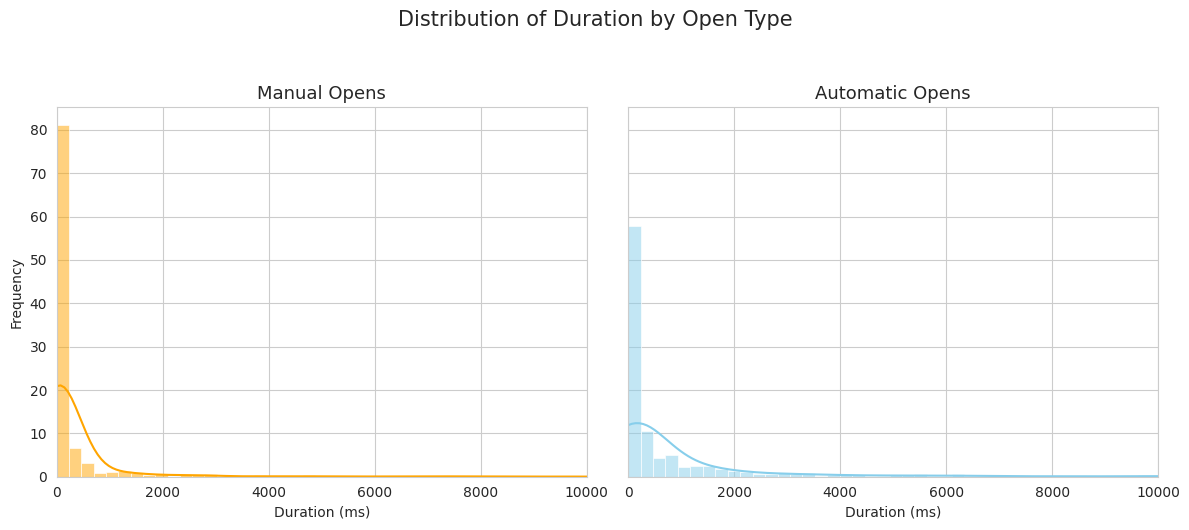

In [ ]:
#Plot histograms for strategy 2
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(
    data=strategy2[strategy2["prev_open_type"] == "manual"],
    x="duration",
    bins=60,
    kde=True,
    color="orange",
    ax=axes[0],
    stat="percent"
)
axes[0].set_title("Manual Opens", fontsize=13)
axes[0].set_xlabel("Duration (ms)")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(0, 10000) 

sns.histplot(
    data=strategy2[strategy2["prev_open_type"] == "auto"],
    x="duration",
    bins=60,
    kde=True,
    color="skyblue",
    ax=axes[1],
    stat="percent"
)
axes[1].set_title("Automatic Opens", fontsize=13)
axes[1].set_xlabel("Duration (ms)")
axes[1].set_xlim(0, 10000)

plt.suptitle("Distribution of Duration by Open Type", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()